<a href="https://colab.research.google.com/github/3catz/deeplearning_timeseries/blob/master/EEG_TCN_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beginnings

In [0]:
from google.colab import files 
import os 
#os.mkdir("/content/subj1")
#os.chdir("/content/subj1")
os.listdir()

from google.colab import auth
auth.authenticate_user()

In [0]:
os.listdir()

['.config', 'adc.json', 'sample_data']

In [0]:
!gsutil -m cp -r gs://peijinbucket/eeg_train /content

Copying gs://peijinbucket/eeg_train/subj10_series1_events.csv...
Copying gs://peijinbucket/eeg_train/subj10_series1_data.csv...
Copying gs://peijinbucket/eeg_train/subj10_series2_data.csv...
Copying gs://peijinbucket/eeg_train/subj10_series2_events.csv...
Copying gs://peijinbucket/eeg_train/subj10_series3_data.csv...
Copying gs://peijinbucket/eeg_train/subj10_series3_events.csv...
Copying gs://peijinbucket/eeg_train/subj10_series4_data.csv...
Copying gs://peijinbucket/eeg_train/subj10_series4_events.csv...
Copying gs://peijinbucket/eeg_train/subj10_series5_data.csv...
Copying gs://peijinbucket/eeg_train/subj10_series5_events.csv...
Copying gs://peijinbucket/eeg_train/subj10_series6_data.csv...
Copying gs://peijinbucket/eeg_train/subj10_series6_events.csv...
Copying gs://peijinbucket/eeg_train/subj10_series7_data.csv...
Copying gs://peijinbucket/eeg_train/subj10_series7_events.csv...
Copying gs://peijinbucket/eeg_train/subj10_series8_data.csv...
Copying gs://peijinbucket/eeg_train/subj1

In [0]:
!gsutil -m cp -r gs://peijinbucket/test /content

Copying gs://peijinbucket/test/subj10_series10_data.csv...
Copying gs://peijinbucket/test/subj12_series9_data.csv...
Copying gs://peijinbucket/test/subj10_series9_data.csv...
Copying gs://peijinbucket/test/subj1_series10_data.csv...
Copying gs://peijinbucket/test/subj11_series10_data.csv...
Copying gs://peijinbucket/test/subj1_series9_data.csv...
Copying gs://peijinbucket/test/subj12_series10_data.csv...
Copying gs://peijinbucket/test/subj11_series9_data.csv...
Copying gs://peijinbucket/test/subj2_series9_data.csv...
Copying gs://peijinbucket/test/subj2_series10_data.csv...
Copying gs://peijinbucket/test/subj3_series10_data.csv...
Copying gs://peijinbucket/test/subj3_series9_data.csv...
Copying gs://peijinbucket/test/subj4_series10_data.csv...
Copying gs://peijinbucket/test/subj4_series9_data.csv...
Copying gs://peijinbucket/test/subj5_series10_data.csv...
Copying gs://peijinbucket/test/subj5_series9_data.csv...
Copying gs://peijinbucket/test/subj6_series10_data.csv...
Copying gs://pei

In [0]:
!pip install -U imbalanced-learn
!pip install keras-tcn
!pip install scikit-multilearn
     

!pip install networkx tensorflow
!git clone https://github.com/thunlp/OpenNE.git
os.chdir("/content/OpenNE/src")
!python setup.py install 
!pip install liac-arff

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.4.3)
    100% |████████████████████████████████| 92kB 3.6MB/s 
Cloning into 'OpenNE'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 537 (delta 0), reused 6 (delta 0), pack-reused 530
Receiving objects: 100% (537/537), 14.93 MiB | 6.61 MiB/s, done.
Resolving deltas: 100% (286/286), done.
running install
running bdist_egg
running egg_info
creating openne.egg-info
writing openne.egg-info/PKG-INFO
writing dependency_links to openne.egg-info/dependency_links.txt
writing top-level names to openne.egg-info/top_level.txt
writing manifest file 'openne.egg-info/SOURCES.txt'
writing manifest file 'openne.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/openne
copying openne/lle.py -> build/

In [0]:
import os 
import numpy as np
import pandas as pd

from glob import glob

from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import StandardScaler
from math import sqrt
from numpy import split, array

from pandas import read_csv
from sklearn.metrics import mean_squared_error, roc_curve, auc
from matplotlib import pyplot
from keras.models import Sequential

from keras.layers import ConvLSTM2D, Dense, Concatenate, Activation, Permute, Lambda, multiply, GlobalMaxPooling1D, Flatten, Bidirectional, TimeDistributed, RepeatVector, LSTM, Dropout, GRU, Conv1D, Conv2D, MaxPooling1D, GlobalMaxPooling1D
from keras.callbacks import *
from keras.constraints import max_norm
from keras.optimizers import *
from sklearn.model_selection import train_test_split
from numpy.random import seed

from keras.models import Input, Model
from keras.regularizers import l2
from keras.utils import to_categorical 
from tcn import TCN
from google.colab import files 
from tensorflow import set_random_seed
set_random_seed(5888)

from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.ext import Keras
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss
#from skmultilearn.base.problem_transformation import LabelPowerset

ImportError: ignored

In [0]:
#############function to read data###########

def prepare_data_train(fname):
    """ read and prepare training data """
    # Read data
    data = pd.read_csv(fname)
    # events file
    events_fname = fname.replace('_data','_events')
    # read event file
    labels= pd.read_csv(events_fname)
    clean=data.drop(['id' ], axis=1)#remove id
    labels=labels.drop(['id' ], axis=1)#remove id
    return  clean,labels
from sklearn.preprocessing import StandardScaler
 
#############function to read data###########

def prepare_data_train(fname):
    """ read and prepare training data """
    # Read data
    data = pd.read_csv(fname)
    # events file
    events_fname = fname.replace('_data','_events')
    # read event file
    labels= pd.read_csv(events_fname)
    clean=data.drop(['id' ], axis=1)#remove id
    labels=labels.drop(['id' ], axis=1)#remove id
    return  clean,labels

def prepare_data_test(fname):
    """ read and prepare test data """
    # Read data
    data = pd.read_csv(fname)
    return data

scaler = StandardScaler()
def data_preprocess_train(X):
    X_prep=scaler.fit_transform(X)
    #do here your preprocessing
    return X_prep

def data_preprocess_test(X):
    X_prep=scaler.transform(X)
    #do here your preprocessing
    return X_prep


In [0]:
from glob import glob
import pandas as pd
import numpy as np 
ids_tot = []
pred_tot = []

y_raw= []
raw = []
for subject in [1]:
  fnames =  glob('/content/eeg_train/subj%d_series*_data.csv' % (subject))
  for fname in fnames:
    data,labels=prepare_data_train(fname)
    raw.append(data)
    y_raw.append(labels)

X = pd.concat(raw)
y = pd.concat(y_raw)
    #transform in numpy array
    #transform train data in numpy array
X_train = np.asarray(X.astype(np.float32))
X_train = data_preprocess_train(X_train)
y = np.asarray(y.astype(np.float32))


test = []
idx=[]
for subject in [1]:
  fnames =  glob('/content/test/subj%d_series*_data.csv' % (subject))
  
  for fname in fnames:
    data=prepare_data_test(fname)
    test.append(data)
    idx.append(np.array(data['id']))
X_test = pd.concat(test)
ids = np.concatenate(idx)
ids_tot.append(ids)
X_test = X_test.drop(['id' ], axis=1)#remove id
    #transform test data in numpy array

X_test = data_preprocess_test(np.array(X_test))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [0]:
X_train.shape, y.shape, X_test.shape

((1422392, 32), (1422392, 6), (233081, 32))

In [0]:
from skmultilearn.problem_transform import LabelPowerset
lp = LabelPowerset()
yt = lp.transform(y)
pd.Series(yt).value_counts()

0     1243589
1       39000
8       27670
6       27670
5       25013
3       22624
7       11330
2        9120
9        7256
10       6731
4        2389
dtype: int64

In [0]:
from imblearn.under_sampling import NearMiss
nmiss = NearMiss(sampling_strategy = {0:20000})

In [0]:
xt_res, yt_res = nmiss.fit_resample(X_train, yt) #undersample and then do the train test split 

In [0]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=12)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [0]:
from sklearn.decomposition import PCA

time_start = time.time()

pca = PCA(n_components=4)
pca_result = pca.fit_transform(X_train)

print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

PCA done! Time elapsed: 4.282570123672485 seconds


In [0]:
pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df['pca3'] = pca_result[:,2]
pca_df['pca4'] = pca_result[:,3]

print('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

Variance explained per principal component: [0.42718203 0.11557017 0.0709432  0.04517946]


(<Figure size 576x576 with 1 Axes>,
 [Text(0.2870195, -0.16683678, '0'),
  Text(-1.0989608, -0.26527518, '1'),
  Text(-1.8227584, -0.9480836, '2'),
  Text(-1.2373312, -0.75737035, '3'),
  Text(-0.8927579, -0.3360269, '4'),
  Text(-1.0467259, -0.6193466, '5'),
  Text(0.30665344, -1.4052598, '6'),
  Text(0.6973564, -1.5040059, '7'),
  Text(-0.13392898, -1.1091388, '8'),
  Text(-1.1093204, -0.366948, '9'),
  Text(-1.3401619, -0.5797329, '10')])

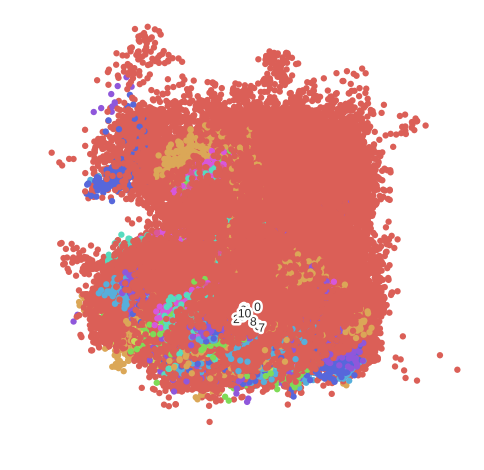

In [0]:
top_two_comp = pca_df[['pca1','pca2']] # taking first and second principal component

fashion_scatter(top_two_comp.values,yt) # Visualizing the PCA output

In [0]:
from sklearn.manifold import TSNE
import time
time_start = time.time()
my_tsne = TSNE(random_state=RS).fit_transform(X_train)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [0]:
fashion_scatter(my_tsne, yt)

In [0]:
pd.Series(yt_res).value_counts()

1    39000
9    20770
7    20770
6    19224
8    18230
3    18041
4    11443
2     9473
5     8290
dtype: int64

In [0]:
!git clone https://github.com/WillKoehrsen/feature-selector.git
os.chdir("feature-selector")
!python setup.py install 

In [0]:
from feature_selector import FeatureSelector
# Features are in train and labels are in train_labels
fs = FeatureSelector(data = pd.DataFrame(xt_res), labels = yt_res)

In [0]:
fs.identify_collinear(correlation_threshold = 0.75)


6 features with a correlation magnitude greater than 0.75.



In [0]:
collinear_features = fs.ops['collinear']
print(collinear_features)
fs.record_collinear.head()


[23, 24, 27, 28, 30, 31]


,corr_feature,corr_value,drop_feature
0,22,0.792700,23
1,23,0.752606,24
2,22,0.766958,27
3,23,0.752740,28
4,29,0.788678,30


In [0]:
xt_slim = pd.DataFrame(xt_res).drop(collinear_features, axis = 1)

In [0]:
x_train, x_val, y_train, y_val = train_test_split(xt_slim, yt_res, test_size = 0.20, shuffle = True)
print(x_train.shape, x_val.shape)

(159042, 26) (39761, 26)


(69639, 31)

In [0]:
fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'auc', 
                            n_iterations = 10, 
                             early_stopping = True)
# list of zero importance features
zero_importance_features = fs.ops['zero_importance']

# Random Forest classifier


In [0]:
from skmultilearn.embedding import SKLearnEmbedder, EmbeddingClassifier
from sklearn.manifold import SpectralEmbedding
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from skmultilearn.adapt import MLkNN



clf = BinaryRelevance(classifier = RandomForestClassifier(n_estimators=20, class_weight = "balanced", verbose=1, max_depth = 5), require_dense=[True,True])

In [0]:
clf.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   34.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   32.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   34.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   33.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   33.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   36.1s finished


BinaryRelevance(classifier=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=4, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=None, oob_score=False,
            random_state=None, verbose=1, warm_start=False),
        require_dense=[True, True])

In [0]:
result = clf.predict(x_val)
result = result.toarray()

from sklearn.metrics import auc, roc_curve
for index in range(6):
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val[:,index], result[:,index])
  auc_keras = auc(fpr_keras, tpr_keras)
  print(auc_keras)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.7035435265161376
0.6631063674452841
0.6504644578526994
0.672597188947326
0.6876487953075281
0.6653013340099502


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.4s finished



# Keras


In [0]:
import sklearn
weights = sklearn.utils.class_weight.compute_class_weight('balanced', range(12), yt)

In [0]:
weights

array([9.54670106e-02, 2.92558654e+00, 1.08272798e+01, 5.62876471e+00,
       1.40601201e+01, 1.43736300e+01, 4.98886666e+00, 4.84811128e+00,
       7.37757428e+00, 4.84811128e+00, 4.26295068e+01, 1.49147549e+03])

In [0]:
y_train = pd.DataFrame(y_train)
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [0]:
y_train.shape

(132192,)

In [0]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
print(y_train.shape, y_val.shape)

(159042, 11) (39761, 11)


In [0]:
x_train.shape

(278553, 32)

In [0]:

import keras 
from keras import backend
from matplotlib import pyplot
from math import pi
from math import cos
from math import floor
checkpointer = keras.callbacks.ModelCheckpoint("subj1.hdf5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=2)

# define custom learning rate schedule
class CosineAnnealingLearningRateSchedule(Callback):
	# constructor
	def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
		self.epochs = n_epochs
		self.cycles = n_cycles
		self.lr_max = lrate_max
		self.lrates = list()

	# calculate learning rate for an epoch
	def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
		epochs_per_cycle = floor(n_epochs/n_cycles)
		cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
		return lrate_max/2 * (cos(cos_inner) + 1)

	# calculate and set learning rate at the start of the epoch
	def on_epoch_begin(self, epoch, logs=None):
		# calculate learning rate
		lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
		# set learning rate
		backend.set_value(self.model.optimizer.lr, lr)
		# log value
		self.lrates.append(lr)
    
ca = CosineAnnealingLearningRateSchedule(n_epochs = 500, n_cycles = 125, lrate_max = 1e-2)

In [0]:
from keras.layers import Reshape
def create_model_single_class(input_dim, output_dim):
    # create model
    i = Input(shape = (26,))
    o = Reshape((1,26))(i)
    o = TCN(64, nb_stacks = 1, dropout_rate = 0.5, use_skip_connections = True, return_sequences = False)(o)
    o = Dense(11, activation = "softmax")(o)
    model = Model(inputs=[i], outputs=[o])
    model.compile(loss='categorical_crossentropy', optimizer = adam(lr=1e-2), metrics=['acc'])
    return model 

model = create_model_single_class(26,11)  

model.fit(x_train, y_train, validation_data = (x_val,y_val), epochs = 500, batch_size = 2048, callbacks = [ca, checkpointer])
#KERAS_PARAMS = dict(epochs=5, batch_size=10000,verbose=1, callbacks = [], class_weight = dict(enumerate(weights)))
#clf = BinaryRelevance(classifier = Keras(create_model_single_class, False, KERAS_PARAMS), require_dense = [True, True]) 
#clf.fit(x_train, y_train)

Train on 159042 samples, validate on 39761 samples
Epoch 1/500
159042/159042 [==============================] - 6s 41us/step - loss: 1.8689 - acc: 0.3517 - val_loss: 1.6678 - val_acc: 0.4132
Epoch 2/500
159042/159042 [==============================] - 3s 21us/step - loss: 1.6568 - acc: 0.4168 - val_loss: 1.5142 - val_acc: 0.4598

Epoch 00002: val_loss improved from inf to 1.51419, saving model to subj1.hdf5
Epoch 3/500
159042/159042 [==============================] - 4s 22us/step - loss: 1.5481 - acc: 0.4476 - val_loss: 1.4080 - val_acc: 0.4899
Epoch 4/500
159042/159042 [==============================] - 3s 22us/step - loss: 1.4750 - acc: 0.4693 - val_loss: 1.3498 - val_acc: 0.5095

Epoch 00004: val_loss improved from 1.51419 to 1.34981, saving model to subj1.hdf5
Epoch 5/500
159042/159042 [==============================] - 3s 22us/step - loss: 1.4854 - acc: 0.4663 - val_loss: 1.3165 - val_acc: 0.5189
Epoch 6/500
159042/159042 [==============================] - 3s 21us/step - loss: 1.4

In [0]:
preds = model.predict(x_val, verbose = 1) ; preds.shape
print(preds)

33049/33049 [==============================] - 4s 129us/step
[[3.39404394e-13 9.93124902e-01 5.23311552e-03 ... 9.34189970e-09
  2.24512542e-06 5.11171929e-05]
 [5.43816334e-08 4.41716518e-03 6.81430250e-02 ... 6.00301973e-07
  9.17529064e-07 9.41763290e-07]
 [1.36317915e-10 1.24232165e-05 1.12054136e-06 ... 1.23332240e-01
  1.37482986e-01 7.39169300e-01]
 ...
 [1.08133129e-08 1.02636106e-02 3.00107840e-02 ... 2.20132605e-08
  4.60885596e-09 5.32618643e-08]
 [6.19726848e-08 9.12420655e-05 4.08950364e-05 ... 1.70677438e-01
  6.05338454e-01 2.23590016e-01]
 [1.07251447e-14 9.99502182e-01 4.46951046e-04 ... 4.28398705e-10
  1.77677439e-09 1.07892335e-08]]


In [0]:
y_classes = preds.argmax(axis=-1)

In [0]:
y_val_classes = y_val.argmax(axis = -1)
print(y_val_classes)

[1 5 9 ... 4 9 1]


In [0]:
from sklearn import metrics
y_classes
br_f1=metrics.f1_score(y_val_classes, y_classes, average='micro')
print(br_f1)

0.704711186420164


In [0]:
result = clf.predict(x_val)
result = result.toarray()

from sklearn.metrics import auc, roc_curve
for index in range(6):
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val[:,index], result[:,index])
  auc_keras = auc(fpr_keras, tpr_keras)
  print(auc_keras)

NameError: ignored

In [0]:
import sklearn.metrics as metrics
for i in range(6):
  y_test = y_val[:,i]
  y_hat = result[:,i]
  br_f1=metrics.f1_score(y_test, y_hat, average='micro')
  br_hamm=metrics.hamming_loss(y_test,y_hat)
  print('Binary Relevance F1-score:',round(br_f1,3))
  print('Binary Relevance Hamming Loss:',round(br_hamm,3))

Binary Relevance F1-score: 0.834
Binary Relevance Hamming Loss: 0.166
Binary Relevance F1-score: 0.812
Binary Relevance Hamming Loss: 0.188
Binary Relevance F1-score: 0.799
Binary Relevance Hamming Loss: 0.201
Binary Relevance F1-score: 0.774
Binary Relevance Hamming Loss: 0.226
Binary Relevance F1-score: 0.874
Binary Relevance Hamming Loss: 0.126
Binary Relevance F1-score: 0.859
Binary Relevance Hamming Loss: 0.141


In [0]:
X_test.shape

(298085, 32)

NameError: ignored

In [0]:
start=time.time()
final_preds=clf.predict(X_test)
print('prediction time taken: ',round(time.time()-start,0),'seconds')
final_preds = final_preds.toarray()

ValueError: ignored

In [0]:
os.chdir("/content")

The all zero target, ie (0,0,0,0,0,0) makes up 87.44% of the data, so it's pretty imbalanced.


In [0]:
print(subject)

# submission file
cols = ['HandStart','FirstDigitTouch',
        'BothStartLoadPhase','LiftOff',
        'Replace','BothReleased']
submission_file = 'TCN_%d_2stacks.csv'
# create pandas object for submission
submission = pd.DataFrame(index = ids,
                          columns = cols,
                          data = final_preds)

# write file
submission.to_csv(submission_file,index_label='id',float_format='%.3f')

2


In [0]:
!gsutil -m cp /content/TCN_2_2stacks.csv gs://peijinbucket

CommandException: No URLs matched: /content/TCN_2_2stacks.csv
CommandException: 1 file/object could not be transferred.


In [0]:
os.listdir()

In [0]:
#ids2 = ids.copy()
#skup to ithe following cell
ids3 = ids.copy()

In [0]:
ids_total = np.concatenate([ids2,ids3])

In [0]:
os.listdir()

['.config',
 'test',
 'adc.json',
 'eeg_train',
 'newTCN4.csv',
 'newTCN3.csv',
 'OpenNE',
 'newTCN2.csv',
 'newTCN1.csv',
 'sample_data']

# See This 

In [0]:
train_gen = BalancedBatchGenerator(trainX, trainY, sampler=RandomOverSampler(sampling_strategy = "minority"), batch_size = 1100, random_state=42)
val_gen = BalancedBatchGenerator(valX, valY, sampler=RandomOverSampler(sampling_strategy = "minority"), batch_size = 1100, random_state=42)
model.fit_generator(train_gen, val_gen, steps_per_epoch = ,epochs = 20, verbose = 1, callbacks = [checkpointer, reduce_lr])

In [0]:
from glob import glob
import pandas as pd
raw = [] 
fnames =  glob('lstm*.csv')
print(fnames)
print(len(fnames))

In [0]:
for fname in fnames:
    dat = pd.read_csv(fname)
    raw.append(dat)
final_submission = pd.concat(raw)

In [0]:
final_submission.shape

In [0]:
final_submission.to_csv("LSTM_TCN_trainedonhalf.csv", sep = ",", header = True, index = False)

In [0]:
!gsutil -m cp LSTM_TCN_trainedonhalf.csv gs://peijinbucket

In [0]:
!gsutil -m cp rounded_final_submission.csv gs://peijinbucket

In [0]:
import numpy as np 
rounded_final = np.round(final_submission)